In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import tables, math, os, sys, scipy
import healpy as hp
import matplotlib.pylab as plt
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
sys.path.append('../')
from core.tools import *
from scipy.interpolate import splrep, splev

from core.tools import _trans

In [4]:
from core.analysis_tools.public_pdfs import *
from core.analysis_tools.amtospheric_background import *
from core.analysis_tools.analysis import ReducedIntegratedSpatialTemplatePowerLawAnalysis
from core.analysis_tools.signal_pdfs import SinglePowerLaw
from core.analysis_tools.basic_spatial_templates import GalacticCenter

In [5]:
effective_areas = EffectiveAreas()
energy_smearing = TrueEnergy2ReconstructedEnergySmearing(
    mc_path='/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')

In [6]:
phi100s = 10**np.linspace(-23,-16, 20)
gammas = np.arange(1.5,4.1,0.25)
signal_model = SinglePowerLaw(phi0_bins=phi100s, gamma_bins=gammas)

In [7]:
gc_template = GalacticCenter(radius_gcenter=15.)

In [8]:
atm_bckg = AtmosphericBackground()

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta /Users/mhuber/AtmosphericShowers/Data/GSF_spline_20171007.pkl.bz2


In [9]:
sindec_bins = np.linspace(-1,1,200)
ra_bins = np.linspace(0, np.pi*2, num=201)
log_ereco_bins = np.arange(2,7.1,0.2)

In [10]:
gc_ana = ReducedIntegratedSpatialTemplatePowerLawAnalysis(sindec_bins, ra_bins, log_ereco_bins,
                          energy_smearing=energy_smearing, 
                          atm_bckg=atm_bckg, effective_areas=effective_areas,
                          livetime=6., signal_model=signal_model, 
                          spatial_template=gc_template)

# Show the template

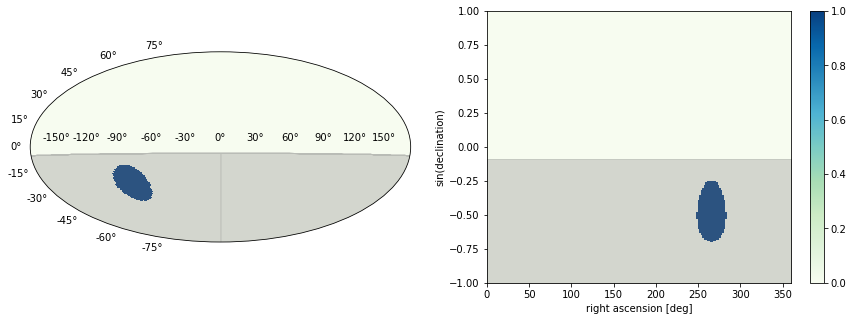

In [11]:
fig = plt.figure(figsize=np.array([15, 5]))
spec = fig.add_gridspec(ncols=2, nrows=1)
ax = fig.add_subplot(spec[0], projection="hammer")
ax2 = fig.add_subplot(spec[1])

lon, lat = _trans(gc_ana.ra_bins,np.arcsin(gc_ana.sindec_bins))

skymap = gc_ana._spatial_template_mask


ax.pcolormesh(lon,lat, skymap.T, cmap='GnBu')
ax.fill_between(np.rad2deg(gc_ana.ra_bins), -np.pi/2*np.ones_like(gc_ana.ra_bins), 
                np.ones_like(gc_ana.ra_bins)*np.deg2rad(-5.),
                color='grey', alpha=0.3)



p=ax2.pcolormesh(np.rad2deg(gc_ana.ra_bins),gc_ana.sindec_bins, skymap.T, 
                  cmap='GnBu')
ax2.fill_between(np.rad2deg(gc_ana.ra_bins), -np.ones_like(gc_ana.ra_bins), 
                 np.ones_like(gc_ana.ra_bins)*np.sin(np.deg2rad(-5.)),
                color='grey', alpha=0.3)

ax2.set_xlabel('right ascension [deg]')
ax2.set_ylabel('sin(declination)')

fig.colorbar(p, ax=ax2)

(25,)
(25,)


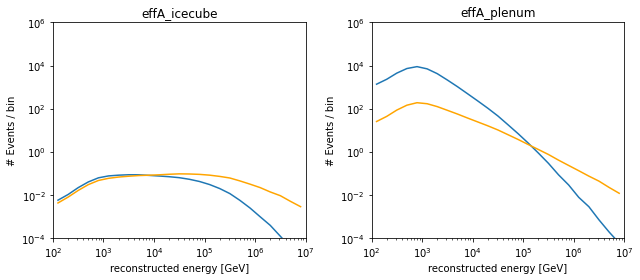

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

d_bckg = gc_ana._generate_background_expectation('numu_conv', astro_bckg=False)
#d_astro = gp_ana._generate_background_expectation(atm_keys=[], astro_bckg=True)
params = [4e-18, 2.7]
d_sig = gc_ana._generate_signal_expectation(params)
for k,exp_key in enumerate(d_bckg.keys()):

    
    ax =axes[k]
    ax.set_title(exp_key)
    
    db = d_bckg[exp_key]
    #da = d_astro[exp_key]
    ds = d_sig[exp_key][0]
    
    print(ds.shape)
    ax.plot(gc_ana.ereco_mids, db)
    #ax.plot(kra_ana.ereco_mids, np.sum(da,axis=(1,2)), color='red')
    ax.plot(gc_ana.ereco_mids, ds, color='orange')
    
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlim(1e2,1e7)
    ax.set_ylim(1e-4,1.e6)
    
    ax.set_xlabel('reconstructed energy [GeV]')
    ax.set_ylabel('# Events / bin')


    
fig.tight_layout()



# Do some background trials 

In [27]:
bckg_trials = gc_ana.do_trials(n_trials=500, 
                               bckg_kwargs =dict(atm_keys=['numu_conv'], 
                                                 astro_bckg=False),
                              integrate=True)

In [28]:
sys.path.append('/Users/mhuber/skylab/SVN_stable_v2-03/')
from _svnskylab.utils import FitDeltaChi2, delta_chi2

0.386
0.262


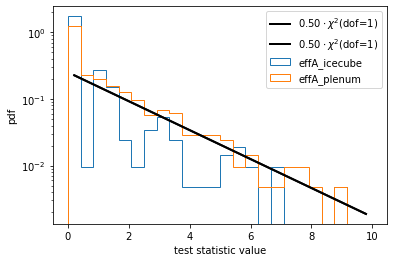

In [29]:
fig, ax = plt.subplots()

ts_bins = np.linspace(0,10,25)
for exp_key, trials in bckg_trials.items():
    ax.hist(trials['ts'], bins=ts_bins, histtype='step', label=exp_key, 
            density=True)
    
    eta = np.sum(trials['ts']==0) / float(len(trials))
    print(eta)
    xvals = get_mids(ts_bins)
    fit_func = delta_chi2(eta=0.5, df=2.)
    fit_vals = fit_func.pdf(xvals)
    fit_vals[:] /= (np.sum(fit_vals) /(fit_func.eta))
    ax.plot(xvals, fit_vals / np.diff(xvals)[0] , color='black', lw=2., 
                label=r'$0.50\cdot \chi^2$(dof=1)')
    
ax.set_xlabel('test statistic value')
ax.set_ylabel('pdf')

ax.legend()
ax.set_yscale('log')



# Do some trials with injected signal to check if it can be recovered


In [31]:
phi0_exp, gamma_exp = 1.44e-18, 2.28
inj_trials = gc_ana.do_trials(n_trials=500, signal_kwargs={'params':[phi0_exp, gamma_exp]},
                               bckg_kwargs =dict(atm_keys=['numu_conv'], astro_bckg=False),
                              integrate=True)

effA_icecube 1.2472987605693582
effA_plenum 10.246238816379599


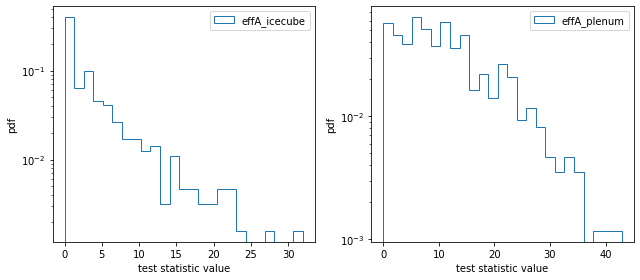

In [32]:
fig, axes = plt.subplots(ncols=2,figsize=(9,4))


for k, (exp_key, trials) in enumerate(inj_trials.items()):
    ax = axes[k]
    h,ts_bins, _= ax.hist(trials['ts'],bins=25, histtype='step', label=exp_key, 
            density=True)
    
    print(exp_key, np.median(trials['ts']))
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('test statistic value')
    ax.set_ylabel('pdf')
    
fig.tight_layout()

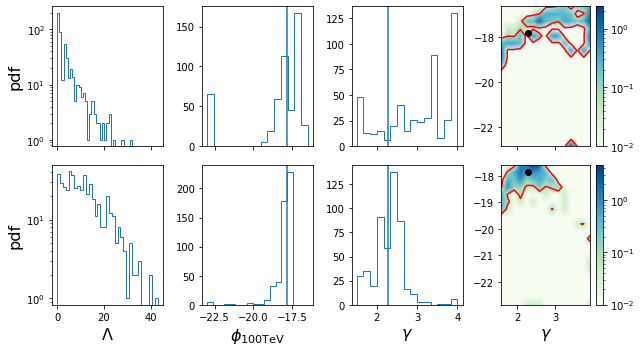

In [33]:
fs=16
fig, axes = plt.subplots(ncols=4,nrows=2,  figsize=(9,5.), sharex='col')

for k, (exp_key,trials) in enumerate(inj_trials.items()):
    
    ################# ts values #######################
    ax = axes[k, 0]
    bins = np.linspace(0,25, 35)
    ax.hist(trials['ts'], bins=35, histtype='step')
    ax.set_yscale('log')
    if k==1:
        ax.set_xlabel(r'$\Lambda$', fontsize=fs)
    ax.set_ylabel(r'pdf', fontsize=fs)
    
    
    ################# phi0 values #######################
    ax = axes[k, 1]
    ax.hist(np.log10(trials['phi0']), bins=15, histtype='step')
    
    ax.axvline(np.log10(phi0_exp))
    if k==1:
        ax.set_xlabel(r'$\phi_{100\mathrm{TeV}}$', fontsize=fs)
    
    ################# gamma values #######################
    ax = axes[k, 2]
    ax.hist(trials['gamma'], bins=15, histtype='step')
    ax.axvline(gamma_exp)
    if k==1:
        ax.set_xlabel(r'$\gamma$', fontsize=fs)
    
    
    ################# 2d phi0-gamma values #######################
    ax = axes[k, 3]
    
    p = np.histogram2d(trials['gamma'], np.log10(trials['phi0']),
              bins=(15, 20),  normed=True)
    
    
    p[0][p[0]<1e-3] = 1e-3
    p0=ax.pcolormesh(get_mids(p[1]), get_mids(p[2]), p[0].T, 
                  cmap='GnBu', norm=LogNorm(), vmin=1e-2, shading='gouraud')
    
    fig.colorbar(p0, ax=ax)
    
    if k==1:
        ax.set_xlabel(r'$\gamma$', fontsize=fs)
    #ax.set_ylabel(r'$\phi_{100\mathrm{TeV}}$', fontsize=fs)
    #fig.colorbar(p[3], ax=ax)
    
    
    # add the contours etc
    
    unc_mat = p[0].flatten()
    X = np.empty((len(unc_mat), ), dtype=[('idx',int), ('p',float)])
    X['idx'] = np.arange(len(unc_mat))
    X['p'] = unc_mat / np.sum(unc_mat) 

    X = np.sort(X,order='p')
    X['p'] = np.cumsum(X['p'])
    X = np.sort(X, order='idx')

    Unc_mat = np.copy(X['p'])

    
    ax.contour(get_mids(p[1]), get_mids(p[2]), Unc_mat.reshape(p[0].shape).T * 100., levels=[5. ], 
                   linestyles = [ 'solid'], colors=['red'])
    

    ax.scatter([gamma_exp], [np.log10(phi0_exp)], marker='o', color='black',
              zorder=10)
    
fig.tight_layout()

# Now calculate the 5 sigma threshold and check which fluxes generate a 5sigma in at least 50% of the cases

In [34]:
ts_5sigma = 18.

In [36]:
n_trials =  int(1e2)

phi_lims = 10**np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 20 )
g_lims = np.arange(np.min(gammas), np.max(gammas), 0.25 )

    
ts_vals = np.zeros((len(phi_lims)*len(g_lims), n_trials), 
                  dtype=[('icecube',float), ('plenum',float)])
XX, YY = np.meshgrid(phi_lims, g_lims, indexing='ij')
    
n=0  
for i, (pi,gj) in enumerate(zip(XX.flatten(), YY.flatten())):    
    inj_trials = gc_ana.do_trials(n_trials=n_trials, signal_kwargs={'params':[pi, gj]},
                               bckg_kwargs =dict(atm_keys=['numu_conv'], astro_bckg=False),
                              integrate=True)
    
    ts_vals['icecube'][i] = inj_trials['effA_icecube']['ts']
    ts_vals['plenum'][i] = inj_trials['effA_plenum']['ts']

    if (i % (ts_vals.shape[0]//10) ==0):
        print('{0}% done!'.format((n+1)*10))
        n+=1
    

10% done!
20% done!
30% done!
40% done!
50% done!
60% done!
70% done!
80% done!
90% done!
100% done!


In [38]:
Fractions = dict()

for k, exp in enumerate(['icecube', 'plenum']):
    
    Fracs = np.zeros(ts_vals.shape[0], dtype=float)
    
    ts_valsi = ts_vals[exp]
    for i, max_vali in enumerate(ts_valsi):
        # calculate the fraction of trials with ts > ts_5sigma
        fraction = np.sum(max_vali >= ts_5sigma) / float(n_trials)
        Fracs[i] = fraction
        

    Fracs = Fracs.reshape(XX.shape)
    Fractions[exp] = Fracs
    

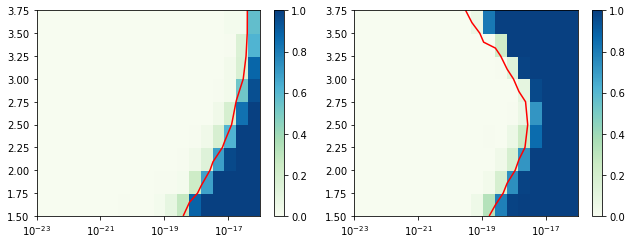

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(9,3.5))

for k, exp in enumerate(['icecube', 'plenum']):
    ax=axes[k]
    Fracs = Fractions[exp]
    p = ax.pcolormesh(phi_lims, 
                      g_lims, 
                      Fracs.T, 
                      vmin=0, vmax=1, cmap='GnBu'
              )

    ax.contour(phi_lims, g_lims, Fracs.T, levels=[0.5], colors=['red'])
    
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

fig.tight_layout()

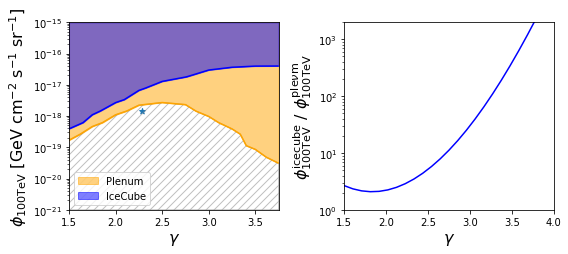

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(8,3.5))


ax = axes[0]

ax.scatter(gamma_exp, phi0_exp, marker='*')
cs = ['blue','orange']
contours=dict()
for k, exp in enumerate(['icecube', 'plenum']):
    
    Fracs = Fractions[exp]
    
    ck = ax.contour( g_lims, phi_lims, Fracs, levels=[0.5], colors=[cs[k]])
    contours[exp] = ck
   
ax.set_yscale('log')
ax.set_ylabel(r'$\phi_{100\mathrm{TeV}}$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]', fontsize=16)
ax.set_xlabel(r'$\gamma$', fontsize=16)
ax.set_ylim(1e-21, 1e-15)

ax = axes[1]
ck_plenum = contours['plenum']
ck_path = ck_plenum.collections[0].get_paths()[0]
g_pl = ck_path.vertices[:,0]
phi_pl = ck_path.vertices[:,1]

ck_icecube = contours['icecube']

g_ice = []
phi_ice = []
for ck_path in ck_icecube.collections[0].get_paths():
    g_ice = np.append(g_ice,ck_path.vertices[:,0])
    phi_ice = np.append(phi_ice, ck_path.vertices[:,1])




g_vals = np.linspace(1.5,4,25)
tck_pl = splrep(g_pl, np.log(phi_pl) , s=1.e-0) 
tck_ice = splrep(g_ice, np.log(phi_ice) , s=1.e-0) 
#ax.plot(g_pl, phi_pl)
#ax.plot(g_vals, np.exp(splev( g_vals, tck_pl)))
#ax.plot(g_vals, np.exp(splev( g_vals, tck_ice)))
ax.plot(g_vals, np.exp(splev( g_vals, tck_ice)) / np.exp(splev( g_vals, tck_pl)) ,c='blue')

axes[0].fill_between(g_pl, phi_pl ,np.ones_like(g_pl)*1e-15, 
                     color='orange', alpha=0.5, label='Plenum')

axes[0].fill_between(g_pl, phi_pl ,np.ones_like(g_pl)*1e-21, 
                     edgecolor='grey', alpha=0.5, hatch='///', facecolor='none')

axes[0].fill_between(g_ice, phi_ice ,np.ones_like(g_ice)*1e-15, 
                     color='blue', alpha=0.5, label='IceCube')
axes[0].legend(loc='lower left')

#ax.plot(g_ice, phi_ice)
ax.set_ylabel(r'$\phi_{100\mathrm{TeV}}^{\mathrm{icecube}}$ / $\phi_{100\mathrm{TeV}}^{\mathrm{ple}\nu\mathrm{m}}$', fontsize=16)
ax.set_xlabel(r'$\gamma$', fontsize=16)
ax.set_xlim(gammas[0], gammas[-1])

ax.set_yscale('log')
ax.set_ylim(1,2e3)

fig.tight_layout()
#fig.savefig('plots/5sigma_discovery_region_galactic_center.pdf')